In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import random
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn

from dll import utils
from dll.utils import HyperParameters
from dll.trainer import Trainer
from dll.dataloader import DataModule
from dll.models import Module

# Linear Neural Networks for Regression

## Synthetic data

In [3]:
class SyntheticData(DataModule):
    def __init__(self, w, b, noise=0.01, 
                 num_train=1000, num_val=1000, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [4]:
data = SyntheticData(w=torch.tensor([2, -3.4]), b=4.2)

In [5]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([ 1.1738, -0.1833]) 
label: tensor([7.1468])


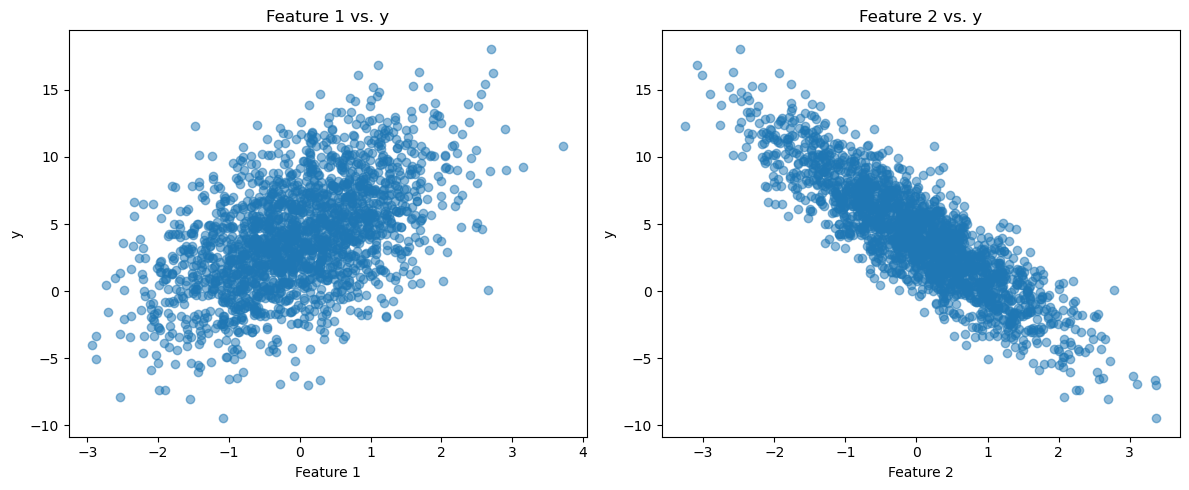

In [6]:
# Extract X and y
X = data.X
y = data.y

# Plot the first feature of X against y
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0].numpy(), y.numpy(), alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('y')
plt.title('Feature 1 vs. y')

# Plot the second feature of X against y
plt.subplot(1, 2, 2)
plt.scatter(X[:, 1].numpy(), y.numpy(), alpha=0.5)
plt.xlabel('Feature 2')
plt.ylabel('y')
plt.title('Feature 2 vs. y')

plt.tight_layout()
plt.show()

In [ ]:
@utils.add_to_class(SyntheticData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train + self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i + self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [ ]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\n shape:', y.shape)

In [7]:
@utils.add_to_class(DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@utils.add_to_class(SyntheticData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [8]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape', y.shape)

X shape: torch.Size([32, 2]) 
y shape torch.Size([32, 1])


In [9]:
len(data.train_dataloader())

32

## From scratch

In [10]:
class LinearRegressionScratch(Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [11]:
@utils.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

In [12]:
@utils.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

In [13]:
class SGD(HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [14]:
@utils.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

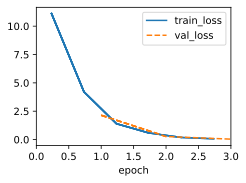

In [15]:
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

In [16]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1267, -0.1440])
error in estimating b: tensor([0.1857])


## Concise implementation

In [17]:
class LinearRegression(Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [18]:
@utils.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

In [19]:
@utils.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [20]:
@utils.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

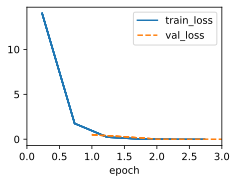

In [21]:
model = LinearRegression(lr=0.03)
data = SyntheticData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

In [22]:
@utils.add_to_class(LinearRegression)
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0063, -0.0063])
error in estimating b: tensor([0.0085])


## Weight Decay

In [ ]:
class Data(DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.5
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [ ]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [ ]:
class WeightDecayScratch(LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) + self.lambd * l2_penalty(self.w))

In [ ]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

In [ ]:
train_scratch(0)

In [ ]:
train_scratch(3)

In [ ]:
class WeightDecay(LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

In [ ]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale = 'log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))